In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.sparse as ss
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
UIMatrix = np.load('UIMatrix.npy')
# UIMatrix = ss.csr_matrix(UIMatrix)
UIMatrix

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2. , 0.5, 0. , ..., 0. , 2. , 0. ],
       [0. , 3. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [3]:
np.load("movie_map.npy")

array([[1.00000e+00, 0.00000e+00],
       [3.00000e+00, 2.00000e+00],
       [6.00000e+00, 5.00000e+00],
       ...,
       [1.68250e+05, 9.44400e+03],
       [1.68252e+05, 9.44500e+03],
       [1.70875e+05, 9.48500e+03]])

In [4]:
row, col, val = ss.find(UIMatrix)
print(row.shape)

(27743,)


24462.237937896898
13008.425595266583
12933.952218230972
12914.254706183658
12906.74404155317
12903.188080524542
训练时间： 670.2031857967377
[12903.183060511737, 12903.178046862162, 12903.173039566866, 12903.16803861643, 12903.163044002173]
2506


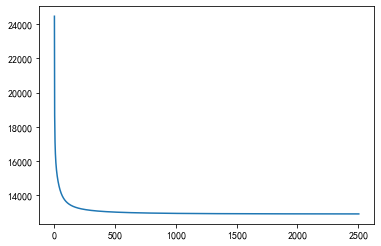

In [3]:
# 逐元素
X = UIMatrix.copy()


# X = np.array([[5, 3, 0, 1],
#               [4, 0, 0, 1],
#               [1, 0, 0, 4],
#               [0, 1, 5, 4],
#               [0, 1, 5, 4],
#               [3,5,0,0]])

def train(loss, lam, k):
    n, m = X.shape
    row, col, val = ss.find(X)

    step = 8e-3
    eps = 5e-3

    # 划分训练集，验证集，测试集
    ziprc = np.array((row, col, val)).T
    np.random.shuffle(ziprc)
    test_size = int(0.18 * ziprc.shape[0])
    validation_size = int(0.18 * ziprc.shape[0])
    test = ziprc[:test_size, :]
    validation = ziprc[test_size:test_size+validation_size, :]
    train = ziprc[test_size+validation_size:, :]

    # 初始化
    P = np.random.rand(n, k)  # 初始化用户矩阵
    Q = np.random.rand(k, m)  # 初始化商品矩阵

    train_x = list(train[:, 0].astype(int))
    train_y = list(train[:, 1].astype(int))

    max_iter = int(5e4)
    lossi_old = 1e6
    start_t = time.time()
    for _ in range(max_iter):
        lossi = 0
        for i, j in zip(train_x, train_y):
            pi = P[i, :]
            qj = Q[:, j]
            eij = X[i, j] - np.dot(pi, qj)
            pi += step * (eij * qj - lam * pi)
            qj += step * (eij * pi - lam * qj)
            lossi += (eij**2 + lam*(np.dot(pi,pi)+np.dot(qj,qj)))
        lossi *= 0.5
        loss.append(lossi)
        if np.abs(lossi - lossi_old) < eps:
            break
        lossi_old = lossi
        if _ % 500 == 0:
            print(lossi)
    print("训练时间：", time.time()-start_t)
    return P, Q, validation, test


loss = []
lam = 0.14 # 正则化系数
k = 18  # 隐空间大小
P, Q, validation, test = train(loss, lam, k)
print(loss[-5:])  # 观察最后loss值
print(len(loss))  # 打印迭代次数
plt.plot(range(len(loss)), loss)
plt.show()

np.save('全批量，无正则化，固定步长loss', np.array(loss))
np.save('全批量，无正则化，固定步长P', P)
np.save('全批量，无正则化，固定步长Q', Q)
np.save('全批量，无正则化，测试集', test)
np.save('全批量，无正则化，验证集', validation)

In [4]:
# 验证集loss
validation_x = list(validation[:, 0].astype(int))
validation_y = list(validation[:, 1].astype(int))
loss = 0
for i, j in zip(validation_x, validation_y):
    r_ij = X[i, j]
    pi = P[i, :]
    qj = Q[:, j]
    r_ij_hat = np.around(pi@qj)
    lossi = (r_ij - r_ij_hat)
    loss += lossi**2 + lam * (np.dot(pi,pi)+np.dot(qj,qj))
    print("r_ij:", r_ij, " r_ij_hat:", r_ij_hat, " loss:", lossi)
print(np.sqrt(loss/len(validation_x)))

r_ij: 2.0  r_ij_hat: 3.0  loss: -1.0
r_ij: 4.0  r_ij_hat: 3.0  loss: 1.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 5.0  r_ij_hat: 3.0  loss: 2.0
r_ij: 2.5  r_ij_hat: 3.0  loss: -0.5
r_ij: 3.5  r_ij_hat: 3.0  loss: 0.5
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 2.0  r_ij_hat: 3.0  loss: -1.0
r_ij: 3.0  r_ij_hat: 4.0  loss: -1.0
r_ij: 3.0  r_ij_hat: 2.0  loss: 1.0
r_ij: 5.0  r_ij_hat: 3.0  loss: 2.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 2.0  r_ij_hat: 3.0  loss: -1.0
r_ij: 1.0  r_ij_hat: 3.0  loss: -2.0
r_ij: 5.0  r_ij_hat: 4.0  loss: 1.0
r_ij: 4.0  r_ij_hat: 3.0  loss: 1.0
r_ij: 1.0  r_ij_hat: 3.0  loss: -2.0
r_ij: 4.0  r_ij_hat: 5.0  loss: -1.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 5.0  r_ij_hat: 4.0  loss: 1.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 4.0  r_ij_hat: 3.0  loss: 1.0
r_ij: 5.0  r_ij_hat: 4.0  loss: 1.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 4.0  r_ij_hat: 3.0  loss: 1.0
r_ij: 3.5  r_ij_hat:

In [13]:
# 测试集
test_x = list(test[:, 0].astype(int))
test_y = list(test[:, 1].astype(int))
loss = 0
for i, j in zip(test_x, test_y):
    r_ij = X[i, j]
    pi = P[i, :]
    qj = Q[:, j]
    r_ij_hat = np.around(P[i, :].T @ Q[:, j])
    lossi = (r_ij - r_ij_hat)
    loss += lossi**2+ lam * (np.dot(pi,pi)+np.dot(qj,qj))
    print("r_ij:", r_ij, " r_ij_hat:", r_ij_hat, " loss:", lossi)
print(np.sqrt(loss/len(test_x)))

r_ij: 4.0  r_ij_hat: 3.0  loss: 1.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 2.5  r_ij_hat: 2.0  loss: 0.5
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 4.0  r_ij_hat: 3.0  loss: 1.0
r_ij: 2.0  r_ij_hat: 4.0  loss: -2.0
r_ij: 5.0  r_ij_hat: 4.0  loss: 1.0
r_ij: 1.0  r_ij_hat: 1.0  loss: 0.0
r_ij: 3.5  r_ij_hat: 3.0  loss: 0.5
r_ij: 5.0  r_ij_hat: 4.0  loss: 1.0
r_ij: 3.0  r_ij_hat: 4.0  loss: -1.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 5.0  r_ij_hat: 3.0  loss: 2.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 5.0  r_ij_hat: 4.0  loss: 1.0
r_ij: 1.0  r_ij_hat: 2.0  loss: -1.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 4.0  r_ij_hat: 4.0  loss: 0.0
r_ij: 4.0  r_ij_hat: 3.0  loss: 1.0
r_ij: 4.0  r_ij_hat: 3.0  loss: 1.0
r_ij: 3.0  r_ij_hat: 2.0  loss: 1.0
r_ij: 3.0  r_ij_hat: 3.0  loss: 0.0
r_ij: 2.0  r_ij_hat: 2.0  loss: 0.0
r_ij: 5.0  r_ij_hat: 5.0  loss: 0.0
r_ij: 3.0  r_ij_hat: 3.0 